Notes on how to init NN before residual connections, batch norms and newer optimizers. Along with bunth of tools on debugging NNs. And Intro to Batch Norm

In [1]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
words = open("./names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n8 = int(0.8 * len(words))
n9 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n8])
Xde, Yde = build_dataset(words[n8:n9])
Xte, Yte = build_dataset(words[n9:])

print(Xtr.shape, Ytr.shape)
print(Xde.shape, Yde.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Looking at Weight Init

In [5]:
n_emb = 10 # number of embedding dim
n_hidden = 200 # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 + b1 # (batch_size, n_hidden)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 #(batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    lr = 0.1 if k < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")
        
    lossi.append(loss.log10().item())

      0/ 200000 28.2624
  10000/ 200000 2.6814
  20000/ 200000 2.6509
  30000/ 200000 2.3491
  40000/ 200000 2.2487
  50000/ 200000 2.3911
  60000/ 200000 2.2728
  70000/ 200000 2.4212
  80000/ 200000 2.6499
  90000/ 200000 2.4655
 100000/ 200000 2.5227
 110000/ 200000 2.3348
 120000/ 200000 1.8785
 130000/ 200000 2.4224
 140000/ 200000 2.1265
 150000/ 200000 2.2104
 160000/ 200000 2.3421
 170000/ 200000 2.4730
 180000/ 200000 2.1818
 190000/ 200000 2.0675


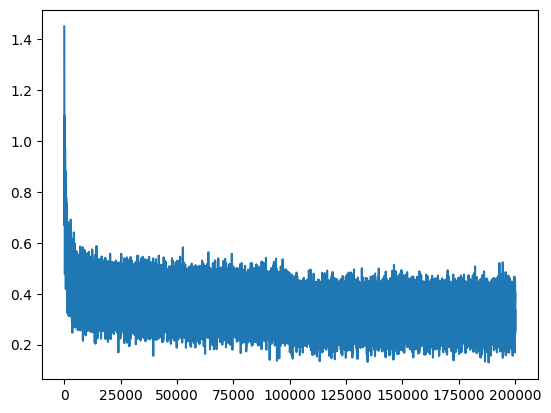

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad() # disables grad tracking
def split_loss(split):
    X, Y = {
        "train": (Xtr, Ytr),
        "dev": (Xde, Yde),
        "test": (Xte, Yte)
    }[split]
    emb = C[X]
    h = torch.tanh( emb.view(-1, 30) @ W1 + b1 )
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item()) 

split_loss('train')
split_loss('dev')

train 2.131348133087158
dev 2.1724977493286133


In [9]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, 10)
        h = torch.tanh( emb.view(-1, n_emb * block_size) @ W1 + b1 )
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        if ix == 0:
            break
        context = context[1:] + [ix]
        out.append(itos[ix])
    
    print(''.join(out))

carlah
amelle
khi
myli
taty
skansh
ej
zhutwayperric
kaquil
ramara
chaiiv
kaleigh
ham
joci
quint
sulin
alianni
watelo
dearyx
kai


### There are 2 issues with training this network

#### 1. Notice loss at 0 is high 

**loss_0 = ~25 and rapidly comes down** - Weights Init is messed up

You would typically want loss such that logits are either 0 or equally distributed initially with a little bit of entropy for exploration. So loss at step 0 should be ~$-\log(1/27.0)$ where 27 is n_class

In [10]:
- torch.tensor(1 / 27.0).log()

tensor(3.2958)

In [11]:
# 4-deminsional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0) # Uniform probs
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [12]:
# 4-deminsional example of the issue
# logits = torch.tensor([-3.0, 5.0, 0.0, 4.0])
logits = torch.randn(4) * 100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([2.0076e-40, 0.0000e+00, 1.0000e+00, 0.0000e+00]), tensor(-0.))

Solution

1. Set last bias to 0s
2. Set the weights to have low values.

Note: Setting to zero might give us the exact loss we are looking for, but it might result in dead neurons.

In [13]:
n_emb = 10  # number of embedding dim
n_hidden = 200  # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # <----
b2 = torch.randn(vocab_size, generator=g) * 0 # <-----

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [14]:
max_steps = 200000
batch_size = 32
lossi = []
h_first, hpreact_first = None, None

for k in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
    h = torch.tanh(hpreact)
    if h_first is None:
        hpreact_first = hpreact
        h_first = h
    logits = h @ W2 + b2  # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if k < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000 3.3170
  10000/ 200000 2.1542
  20000/ 200000 2.0900
  30000/ 200000 2.6011
  40000/ 200000 1.9522
  50000/ 200000 2.1896
  60000/ 200000 1.9801
  70000/ 200000 2.1080
  80000/ 200000 1.9275
  90000/ 200000 2.2718
 100000/ 200000 2.1447
 110000/ 200000 1.9327
 120000/ 200000 1.7188
 130000/ 200000 2.0356
 140000/ 200000 1.8019
 150000/ 200000 2.0935
 160000/ 200000 2.0786
 170000/ 200000 1.5726
 180000/ 200000 2.1461
 190000/ 200000 2.2580


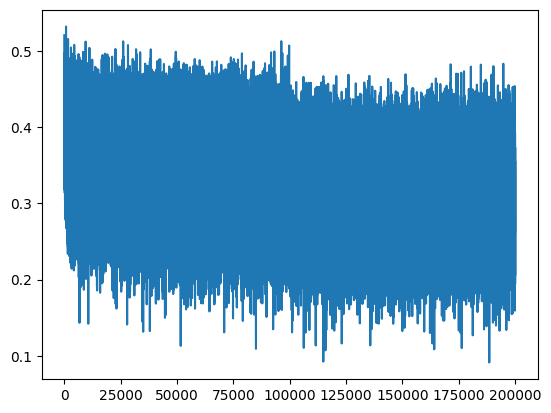

In [15]:
plt.plot(lossi)

In [16]:
@torch.no_grad()  # disables grad tracking
def split_loss(split):
    X, Y = {"train": (Xtr, Ytr), "dev": (Xde, Yde), "test": (Xte, Yte)}[split]
    emb = C[X]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())


split_loss("train")
split_loss("dev")

train 2.0703723430633545
dev 2.1317663192749023


#### 2. Dead Neurons

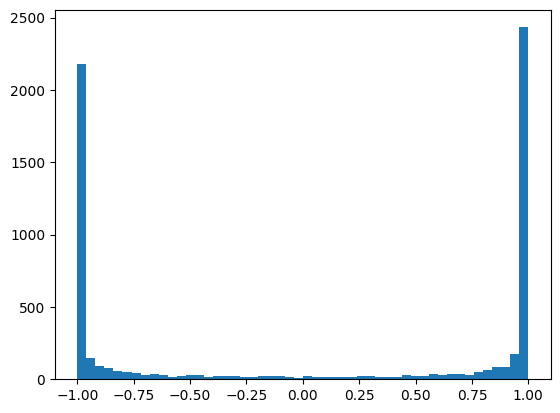

In [17]:
plt.hist(h_first.view(-1).tolist(), bins=50);

Tanh activations are saturated to -1s and 1.

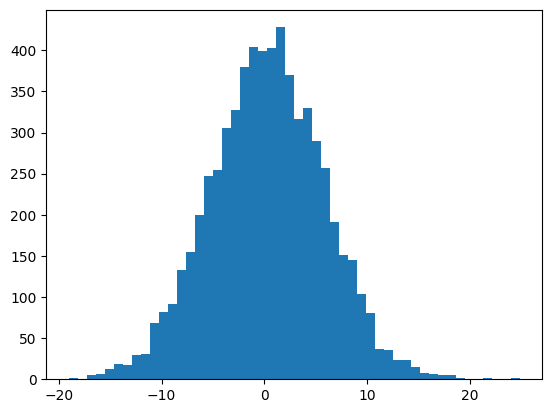

In [18]:
plt.hist(hpreact_first.view(-1).tolist(), bins=50);

H preactivations are every brawd. from -15 to 15, causing tanh to mostly saturate at -1 and 1.

Why this is a problem. - Because tanh's gradient at -1 or 1 is zero. If during init all inputs to that neuron produces -1 or 1. This neuron won't learn anything at any point as the gradient passing through this will be zeroing out - Causing this neuron to be dead

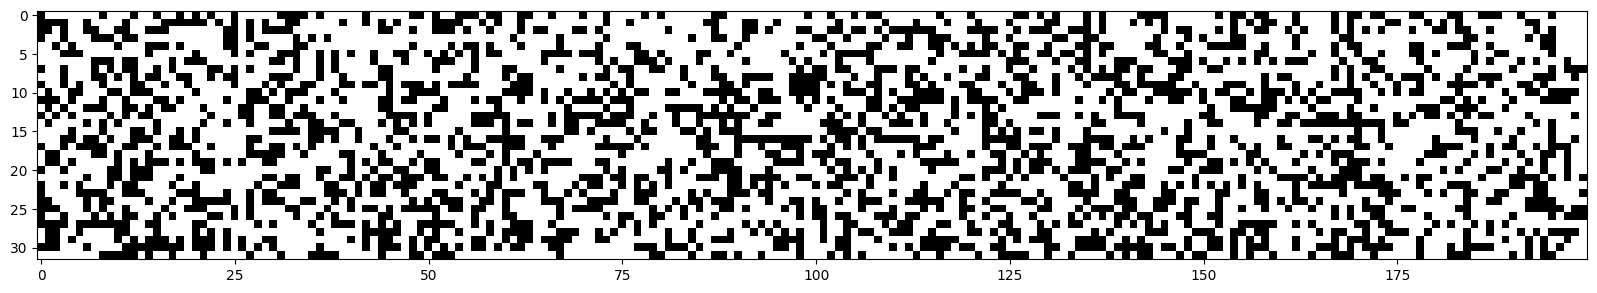

In [19]:
plt.figure(figsize=(20, 10))
plt.imshow(h_first.abs() > 0.99, cmap='gray', interpolation='nearest') # White true, black false

We are lucky here, as there no column that is entirely white / true, so no dead neuron

**This can happen to other activations as well**

**This can happen in the middle of training as well, when learning rate is very high causing neurons/activations to saturate at position where grads would be zero - causing brain damage**

In [20]:
n_emb = 10  # number of embedding dim
n_hidden = 200  # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * 0.2 # <---------
b1 = torch.randn(n_hidden, generator=g)                         * 0 # <----
W2 = torch.randn((n_hidden, vocab_size), generator=g)           * 0.01 # <----
b2 = torch.randn(vocab_size, generator=g)                       * 0 # <-----

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [21]:
max_steps = 200000
batch_size = 32
lossi = []
h_first, hpreact_first = None, None

for k in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
    h = torch.tanh(hpreact)
    if h_first is None:
        hpreact_first = hpreact
        h_first = h
    logits = h @ W2 + b2  # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if k < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000 3.2905
  10000/ 200000 2.2851
  20000/ 200000 2.4621
  30000/ 200000 2.1374
  40000/ 200000 1.7031
  50000/ 200000 1.8675
  60000/ 200000 2.0440
  70000/ 200000 2.1245
  80000/ 200000 2.1000
  90000/ 200000 2.1130
 100000/ 200000 2.4751
 110000/ 200000 1.9008
 120000/ 200000 1.7614
 130000/ 200000 1.9304
 140000/ 200000 2.2593
 150000/ 200000 1.8514
 160000/ 200000 1.8863
 170000/ 200000 2.2257
 180000/ 200000 2.2080
 190000/ 200000 1.8942


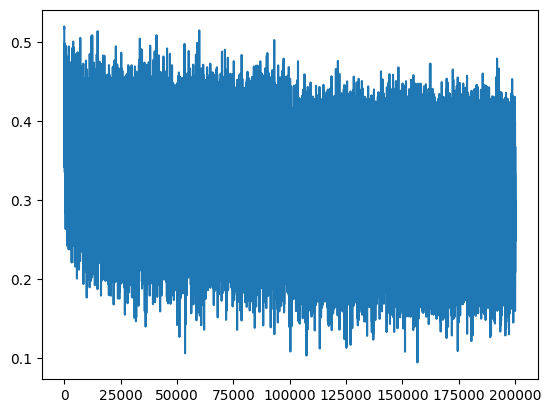

In [22]:
plt.plot(lossi)

In [23]:
@torch.no_grad()  # disables grad tracking
def split_loss(split):
    X, Y = {"train": (Xtr, Ytr), "dev": (Xde, Yde), "test": (Xte, Yte)}[split]
    emb = C[X]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())


split_loss("train")
split_loss("dev") 

train 2.034884452819824
dev 2.099763870239258


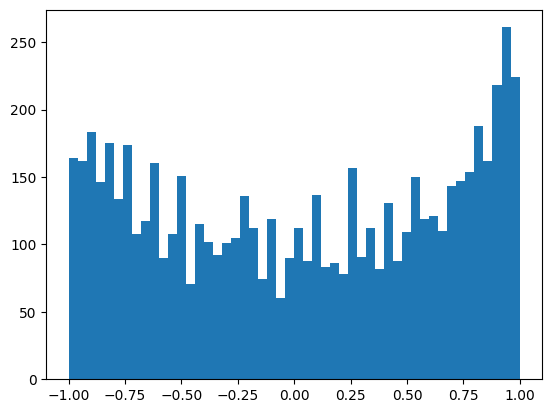

In [24]:
plt.hist(h_first.view(-1).tolist(), bins=50);

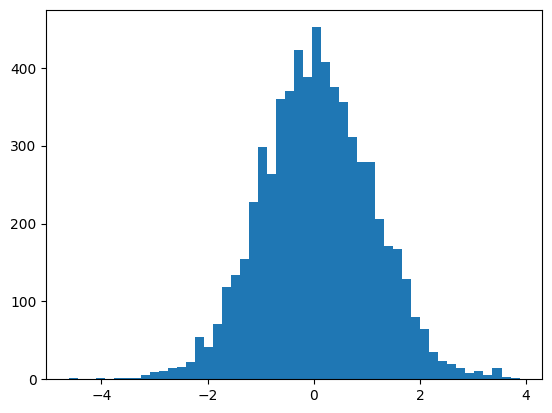

In [25]:
plt.hist(hpreact_first.view(-1).tolist(), bins=50);

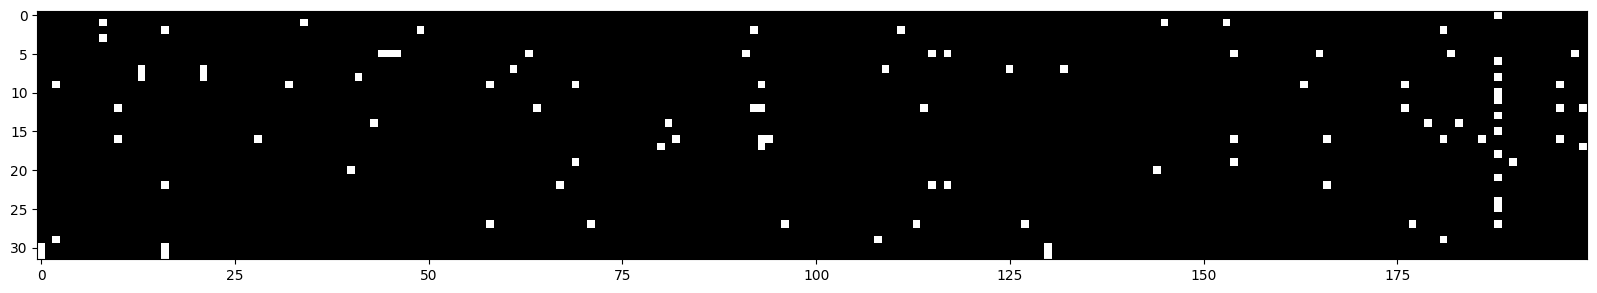

In [26]:
plt.figure(figsize=(20, 10))
plt.imshow(h_first.abs() > 0.99, cmap='gray', interpolation='nearest') # White true, black false

Much better with a little bit of entropy

### Closer look at standard init'ing

tensor(0.0036) tensor(0.9961)
tensor(-0.0013) tensor(3.1359)


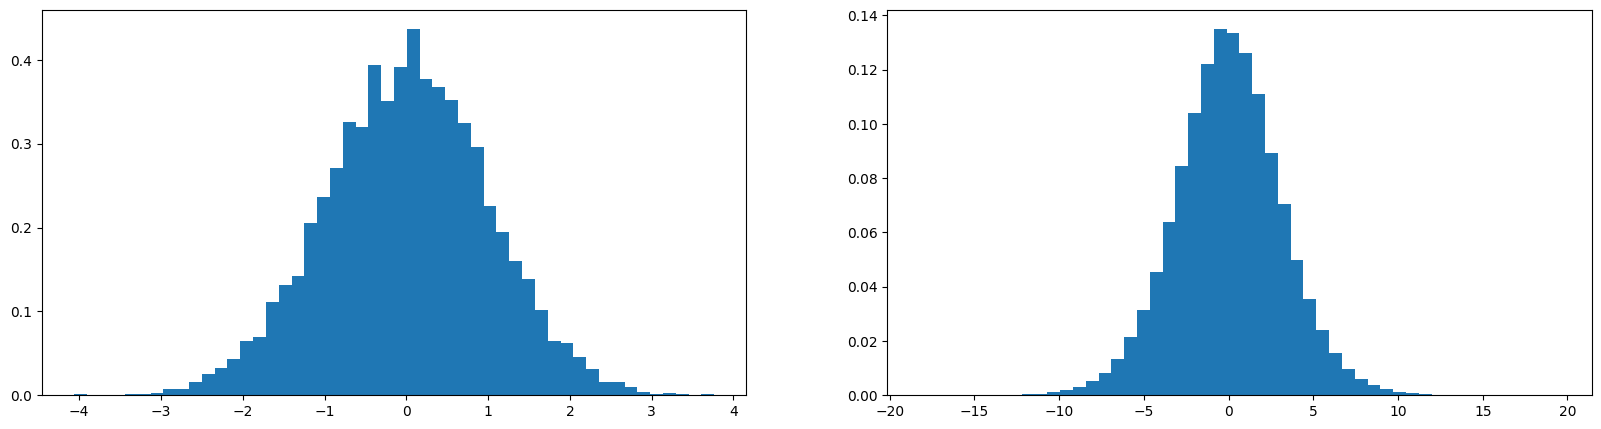

In [27]:
X = torch.randn(1000, 10)
W = torch.randn(10, 200)
y = X @ W # forget bias and non liniearity
print(X.mean(), X.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(X.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

If we see X's std is 1 as expected with randn init, but y's std is expanded to 3.12. This is the problem causing y to take extreme randes (-10 to 10 in the plot) causing activations to take extreme (no grad) positions

Solution: the wieght scale / std should be set to $\frac{1}{\sqrt{fan\_in}}$ where $fan\_in$ is input dimension (in prev example 10)

tensor(-0.0054) tensor(0.9932)
tensor(0.0022) tensor(0.9835)


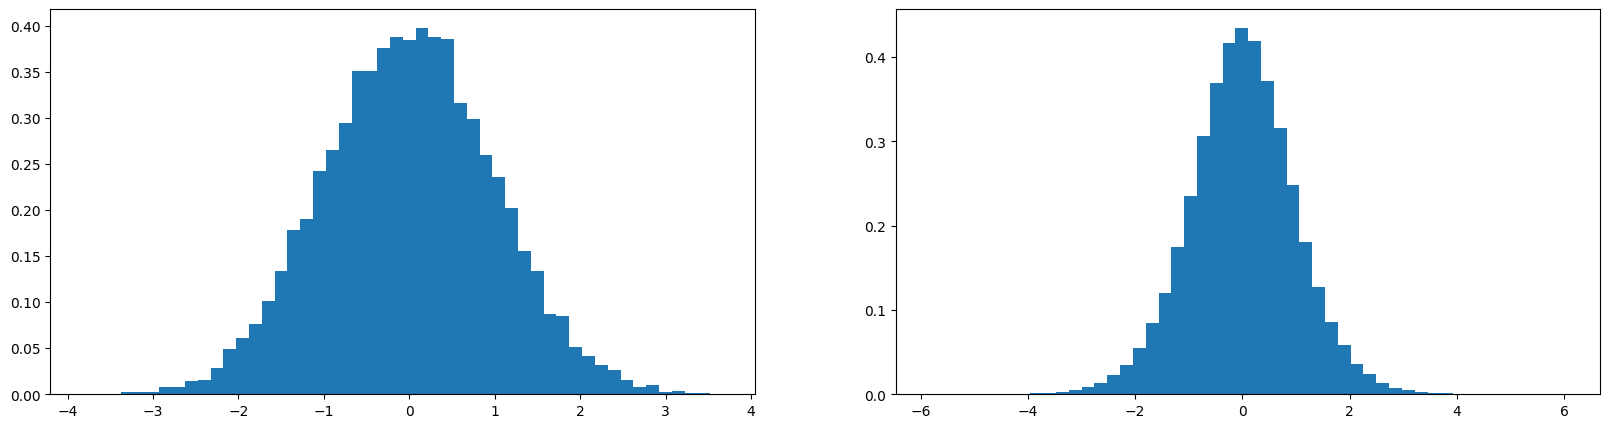

In [28]:
X = torch.randn(1000, 10)
W = torch.randn(10, 200) / 10**0.5
y = X @ W # forget bias and non liniearity
print(X.mean(), X.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(X.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Now considering activations check [this paper](https://arxiv.org/pdf/1502.01852). This paper looked at CNNs with ReLU, PReLU but almost the same thing can be replicated to other actiovations as well.

Quick TLDR:

- Since ReLU is a squashing function that removes -ve values - half of the distribution is lost so the weight stddev should be $\sqrt{\frac{2}{fan\_in}}$
- If forward pass is properly init'd then backward pass it taken care of but up to point of depth of the NN - See paper.

pytorch implementation - https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

Extanding same for tanh the weight stddev will be 

$$\frac{\frac{5}{3}}{\sqrt{fan\_in}}$$

Note: fan_in is nothing but the input dim to a Linear Layer - for example nn.Linear(1000, 500) fan_in is 1000

In [29]:
(5/3) / ((n_emb * block_size) ** 0.5)

0.3042903097250923

In [30]:
n_emb = 10  # number of embedding dim
n_hidden = 200  # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)   * ((5/3) / ((n_emb * block_size) ** 0.5)) # 0.2 (old) # <---------
b1 = torch.randn(n_hidden, generator=g)                         * 0 # <----
W2 = torch.randn((n_hidden, vocab_size), generator=g)           * 0.01 # <----
b2 = torch.randn(vocab_size, generator=g)                       * 0 # <-----

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [31]:
max_steps = 200000
batch_size = 32
lossi = []
h_first, hpreact_first = None, None

for k in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
    h = torch.tanh(hpreact)
    if h_first is None:
        hpreact_first = hpreact
        h_first = h
    logits = h @ W2 + b2  # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if k < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000 3.2918
  10000/ 200000 2.1804
  20000/ 200000 1.8272
  30000/ 200000 2.0436
  40000/ 200000 1.7015
  50000/ 200000 2.2041
  60000/ 200000 2.1847
  70000/ 200000 1.8857
  80000/ 200000 2.2150
  90000/ 200000 2.1387
 100000/ 200000 2.0406
 110000/ 200000 2.0558
 120000/ 200000 1.7994
 130000/ 200000 2.1588
 140000/ 200000 1.5805
 150000/ 200000 2.0740
 160000/ 200000 1.8557
 170000/ 200000 2.3610
 180000/ 200000 2.1285
 190000/ 200000 2.3127


In [32]:
@torch.no_grad()  # disables grad tracking
def split_loss(split):
    X, Y = {"train": (Xtr, Ytr), "dev": (Xde, Yde), "test": (Xte, Yte)}[split]
    emb = C[X]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())


split_loss("train")
split_loss("dev") 

train 2.0376272201538086
dev 2.1046838760375977


### Weight Init Conclusion

These precise setting is almost made obsolete because of modern day innovations namely

1. Residual Connections
2. Normalization layers like Batch Norm, Layer Norm, Instance Norm etc
3. More powerfull optimizers like RMSProp, Adam etc

## Batch Normalization

Batch Normalization is a technique to stabilize and speed up training in deep neural networks by normalizing the inputs of each layer.

- It does this by normalizing the hidden state to be roughly gaussian. Gaussian initally, later allows scaling and shifting the normalized values with learned parameters (gamma, beta) to maintain model capacity.
- Helps reduce internal covariate shift (changing input distributions).
- Leads to stable training, reduced dependence on weight init'n and learning rate (to an extent)
- Often leads to better generalization - as the gamma, betta changes -> leads to tiny changes in input -> leading to generalization.

**Con**
- Samples are "combined / coupled" inside a batch. This can be good as regularizer

### Formulation

**Init**
$$
\gamma = \mathbf{1}_{1 \times m}, \quad \beta = \mathbf{0}_{1 \times m}
$$
where $m$ is batch size

**During Training**

Hidden state will be normalized
$$
\mu_B = \frac{1}{m} \sum_{i=1}^m x_i \\
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2 \\
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$
$\epsilon$ is usually $e^{-5}$ to prevent divide by 0

Normalized preactvations will be scaled and shifted using $\gamma$ and $\beta$
$$
\hat{x}_i = \gamma \hat{x}_i + \beta
$$

Typically running $\mu$ and $\sigma$ will be maintained to be used during inference
$$
\mu_{\text{running}} \leftarrow (1 - \alpha) \cdot \mu_{\text{running}} + \alpha \cdot \mu_B \\
\alpha = 0.001
$$

**During Inference**

hidden states are normalized using running stats maintained during training
$$
\hat{x}_i = \frac{x_i - \mu_{\text{running}}}{\sqrt{\sigma^2_{\text{running}} + \epsilon}}
$$

Normalized preactvations will be scaled and shifted using $\gamma$ and $\beta$
$$
\hat{x}_i = \gamma \hat{x}_i + \beta
$$

In [33]:
n_emb = 10  # number of embedding dim
n_hidden = 200  # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)   * ((5/3) / ((n_emb * block_size) ** 0.5)) # 0.2 (old) # <---------
# b1 = torch.randn(n_hidden, generator=g)                         * 0 # <----
W2 = torch.randn((n_hidden, vocab_size), generator=g)           * 0.01 # <----
b2 = torch.randn(vocab_size, generator=g)                       * 0 # <-----

# ---------- Batch Normalization Param -------
## -- Learnable PArams
bngain = torch.ones((1, n_hidden))  # gamma
bnbias = torch.zeros((1, n_hidden))  # beta
## -- Running stats
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
# ---------------------------------------------

# parameters = [C, W1, b1, W2, b2, bnbias, bngain]
parameters = [C, W1, W2, b2, bnbias, bngain] # bias removed
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [34]:
max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 # + b1  # (batch_size, n_hidden)
    
    # -------- Batch Normalization ---------
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    # --------------------------------------
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2  # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if k < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000 3.2622
  10000/ 200000 2.2888
  20000/ 200000 2.5541
  30000/ 200000 2.0920
  40000/ 200000 2.1560
  50000/ 200000 2.2466
  60000/ 200000 1.7642
  70000/ 200000 2.0280
  80000/ 200000 2.3974
  90000/ 200000 2.2750
 100000/ 200000 2.0784
 110000/ 200000 2.3955
 120000/ 200000 2.2706
 130000/ 200000 2.2718
 140000/ 200000 2.2228
 150000/ 200000 2.3688
 160000/ 200000 1.7685
 170000/ 200000 2.4445
 180000/ 200000 2.1232
 190000/ 200000 2.2221


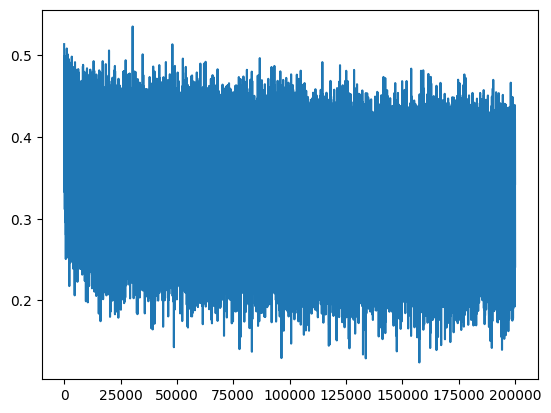

In [35]:
plt.plot(lossi)

In [36]:
@torch.no_grad()  # disables grad tracking
def split_loss(split):
    X, Y = {"train": (Xtr, Ytr), "dev": (Xde, Yde), "test": (Xte, Yte)}[split]
    emb = C[X]
    hpreact = emb.view(-1, 30) @ W1 # + b1
    # -------- Batch Normalization ---------
    hpreact = (bngain * (hpreact - bnmean_running) / bnstd_running + bnbias)
    # -------------------------------------
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())


split_loss("train")
split_loss("dev")

train 2.068204402923584
dev 2.108837127685547


**Note** biases are useless as the hidden state is normalized. so not be wastefull as set `use_bias=False` in Linear (/Conv) layers when using batch norm

## PyTorchify

In [37]:
# The classes we create here are the same API as nn.Module in PyTorch
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [38]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

# weight init / update
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 # <----- Note: No gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [39]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break  # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.3099


layer 1 (      Tanh): mean +0.01, std 0.61, saturated: 2.62%
layer 3 (      Tanh): mean +0.02, std 0.47, saturated: 0.03%
layer 5 (      Tanh): mean +0.01, std 0.40, saturated: 0.00%
layer 7 (      Tanh): mean -0.02, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.33, saturated: 0.00%


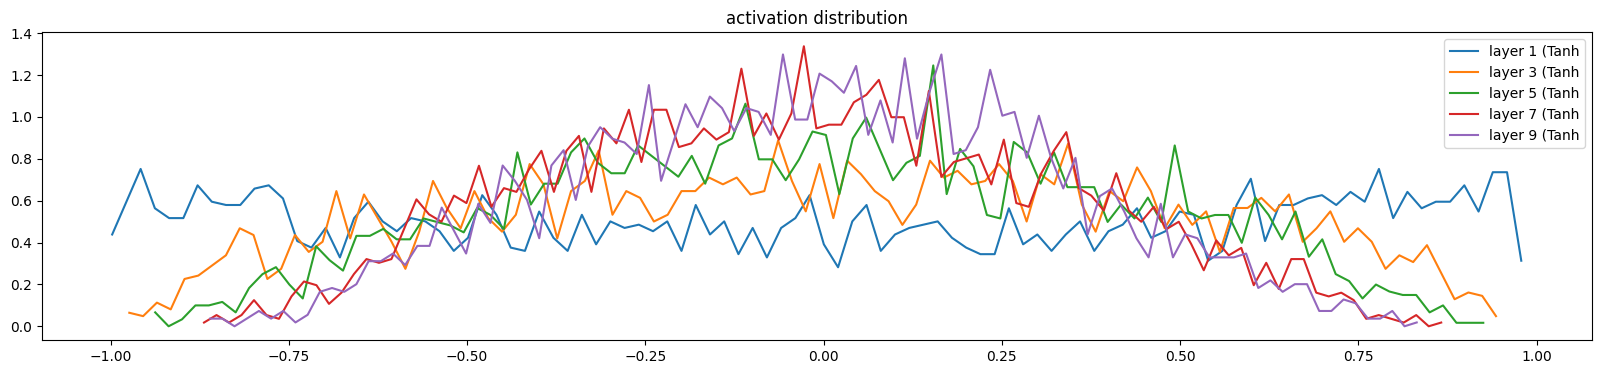

In [40]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"% (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100,))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution");


When gain is set to 1 with weight init to $\frac{1}{\sqrt{fan\_in}}$, this because the Linear layers are interspersed with Tanh layers, the activations in the later layers are squashed (having less std compared to prev layer). This is because tanh is a squashing function. So the gain should be set, in this case of Tanh 5/3 to negat this squashing. Also to high of a gain will cause more saturation so increase in chance of dead neurons

layer 1 (      Tanh): mean +0.000002, std 1.668444e-04
layer 3 (      Tanh): mean +0.000005, std 2.075935e-04
layer 5 (      Tanh): mean -0.000002, std 2.471255e-04
layer 7 (      Tanh): mean +0.000010, std 2.803162e-04
layer 9 (      Tanh): mean -0.000004, std 3.112020e-04


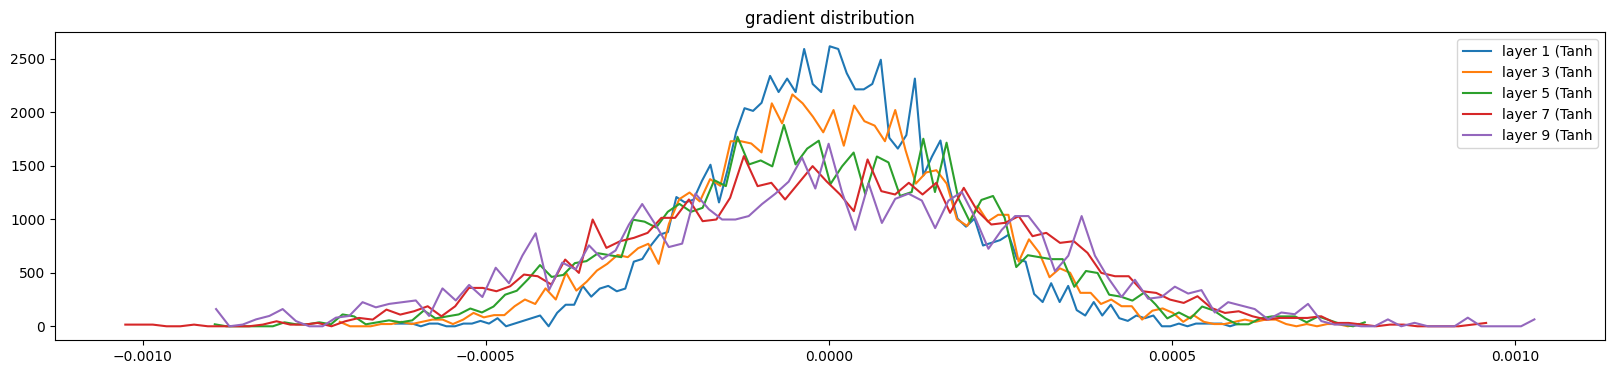

In [41]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e"% (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution");


In [42]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

# weight init / update
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # <----- Proper gain for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [43]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break  # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.3236


layer 1 (      Tanh): mean +0.02, std 0.74, saturated: 17.56%
layer 3 (      Tanh): mean +0.02, std 0.68, saturated: 9.25%
layer 5 (      Tanh): mean +0.01, std 0.67, saturated: 6.91%
layer 7 (      Tanh): mean -0.03, std 0.65, saturated: 5.53%
layer 9 (      Tanh): mean -0.01, std 0.66, saturated: 6.75%


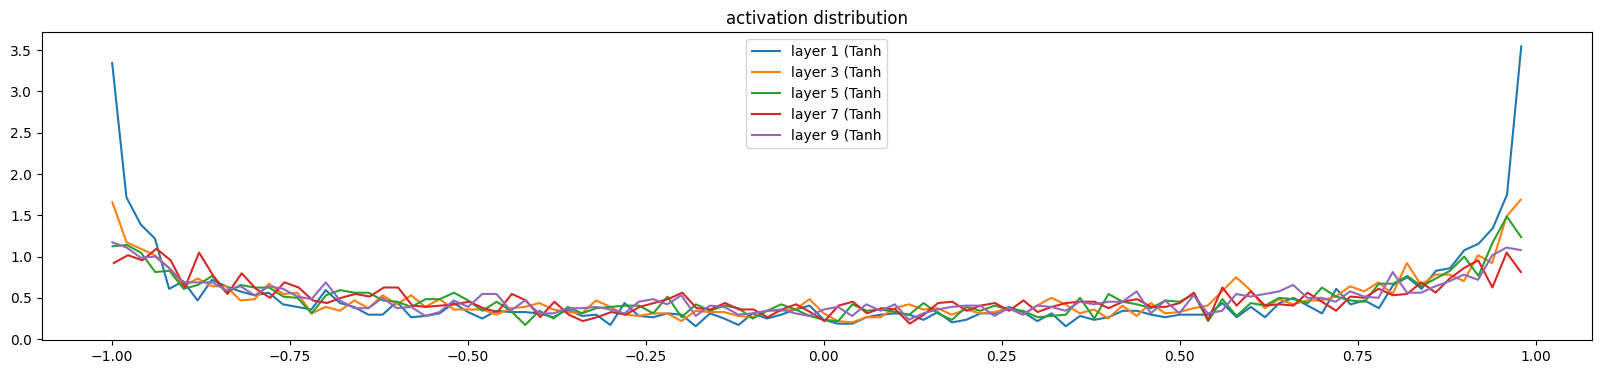

In [44]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"% (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100,))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution");


std is roughly maintained compared to previous layers. And saturations are low. High in the first layer but thats ok.

layer 1 (      Tanh): mean +0.000009, std 3.851270e-04
layer 3 (      Tanh): mean +0.000006, std 3.768252e-04
layer 5 (      Tanh): mean -0.000006, std 3.712745e-04
layer 7 (      Tanh): mean +0.000010, std 3.434150e-04
layer 9 (      Tanh): mean -0.000004, std 3.114217e-04


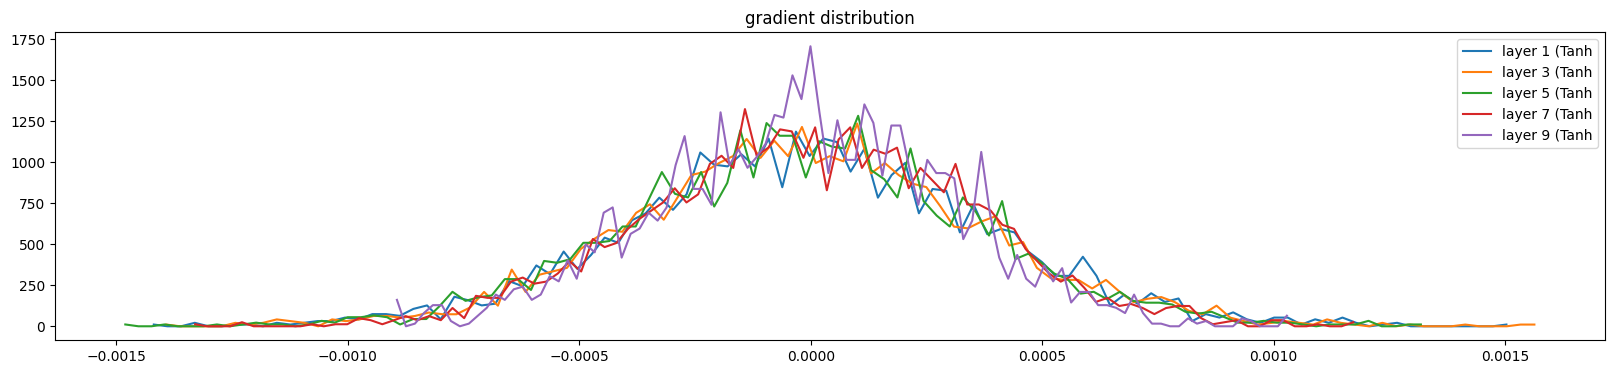

In [45]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e"% (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution");

Gradients should roughly have same distribution between layers. This is not the case when gain is set too low. Example below

In [46]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

# weight init / update
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5 # <----- Low gain causes imbalance in gradient distributions between layers

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [47]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break  # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.2968


layer 1 (      Tanh): mean +0.01, std 0.40, saturated: 0.00%
layer 3 (      Tanh): mean +0.01, std 0.19, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.09, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.05, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.02, saturated: 0.00%


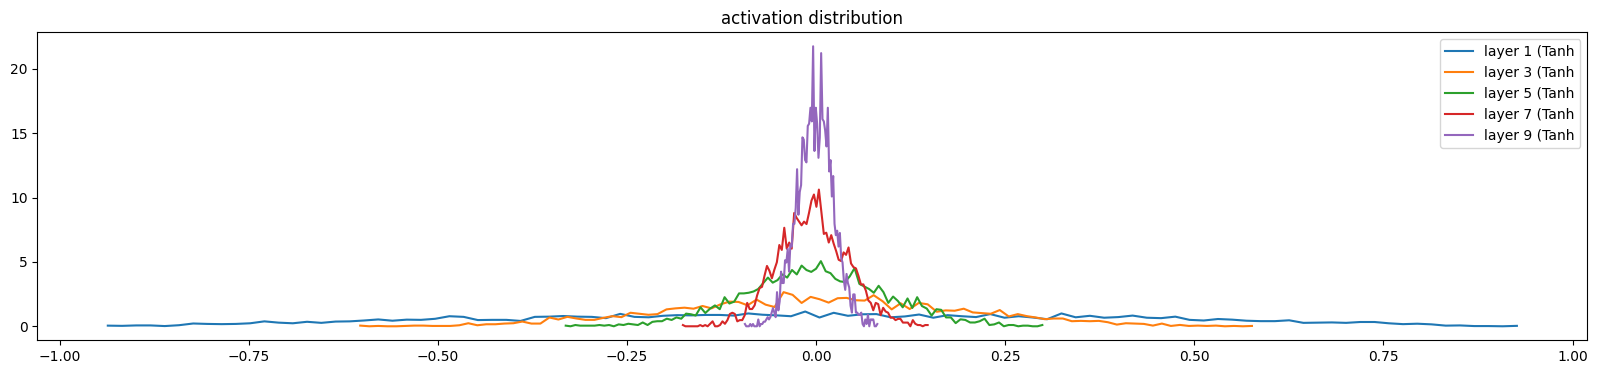

In [48]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"% (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100,))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution");

When weight scale is low, activations are squashed as the layer deepens

layer 1 (      Tanh): mean -0.000000, std 1.868804e-05
layer 3 (      Tanh): mean +0.000001, std 3.797134e-05
layer 5 (      Tanh): mean -0.000000, std 7.732961e-05
layer 7 (      Tanh): mean +0.000005, std 1.545720e-04
layer 9 (      Tanh): mean -0.000004, std 3.109863e-04


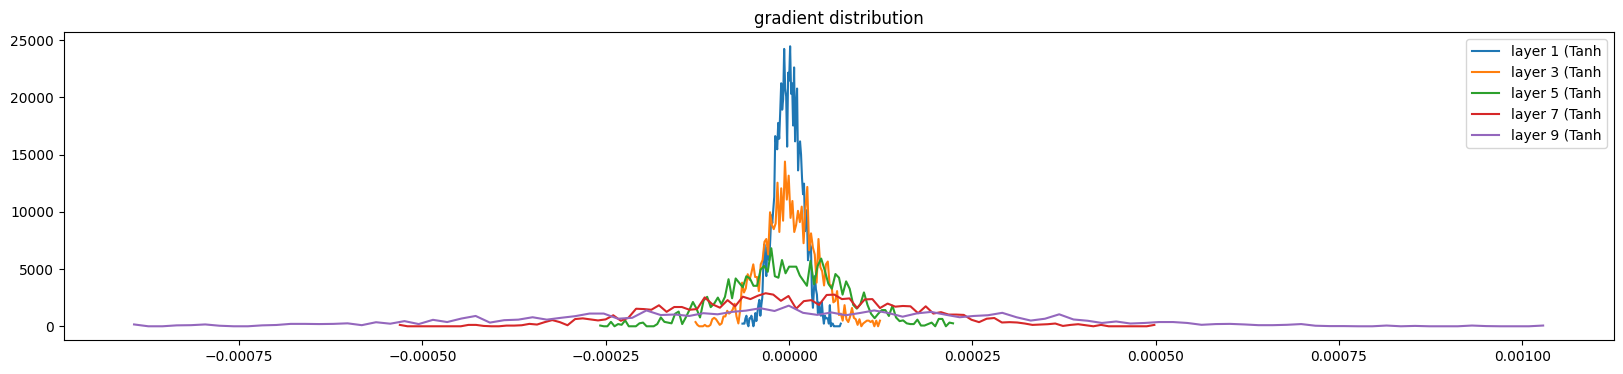

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e"% (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution");

First layer's gradient is squashed and slowly getting unsquashed as the layer deepens. This is not ideal

In [50]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

# weight init / update
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [51]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000: 
        break  # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.3235


layer 1 (      Tanh): mean +0.01, std 0.77, saturated: 23.41%
layer 3 (      Tanh): mean -0.01, std 0.71, saturated: 11.03%
layer 5 (      Tanh): mean -0.02, std 0.72, saturated: 10.94%
layer 7 (      Tanh): mean -0.05, std 0.74, saturated: 11.62%
layer 9 (      Tanh): mean -0.01, std 0.73, saturated: 12.19%


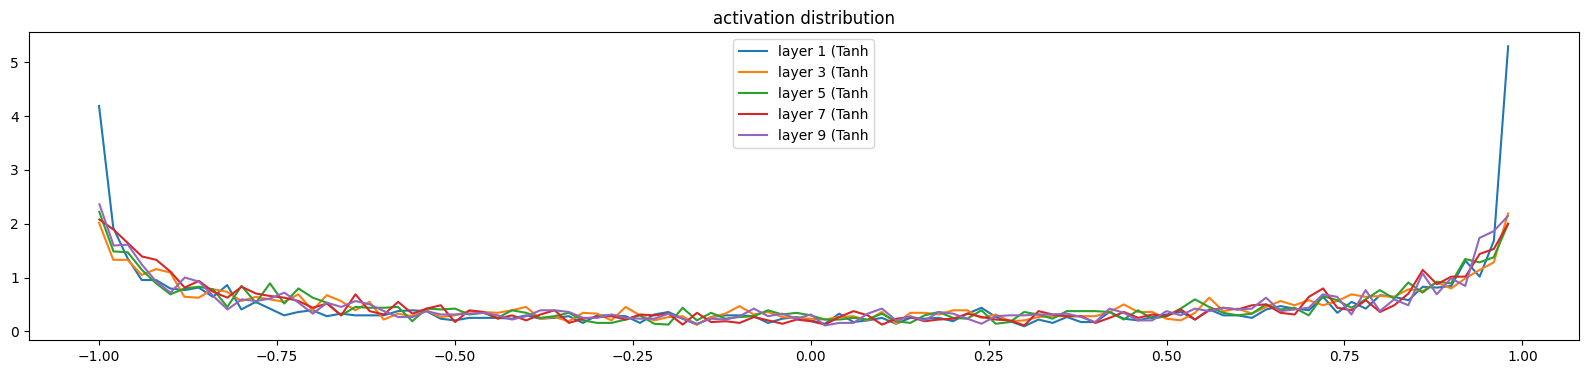

In [52]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"% (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100,))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution");

layer 1 (      Tanh): mean -0.000076, std 2.873844e-03
layer 3 (      Tanh): mean +0.000028, std 2.735388e-03
layer 5 (      Tanh): mean +0.000043, std 2.642376e-03
layer 7 (      Tanh): mean -0.000024, std 2.556231e-03
layer 9 (      Tanh): mean -0.000031, std 2.210588e-03


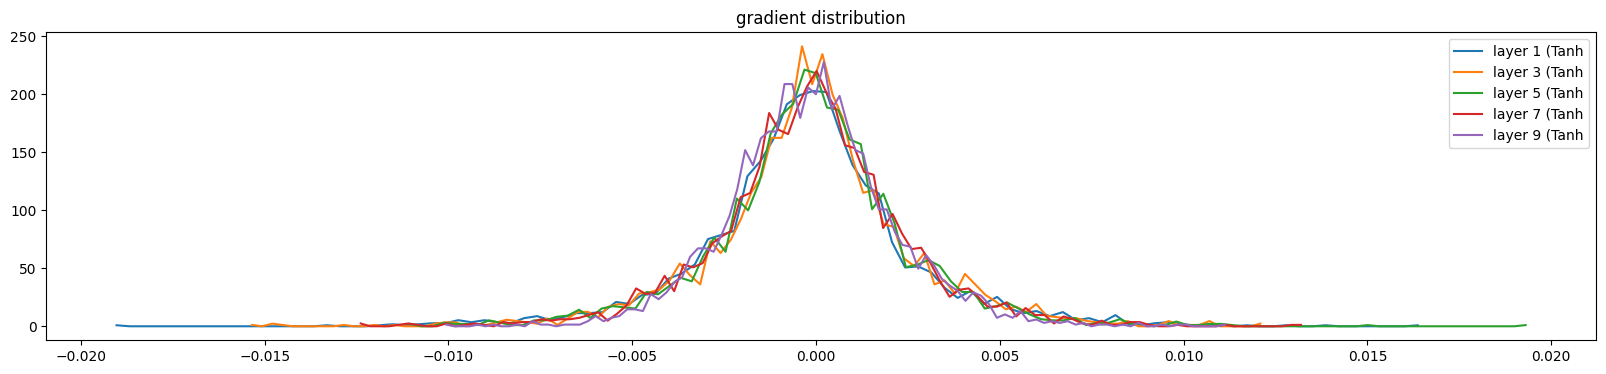

In [53]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e"% (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution");

weight   (27, 10) | mean +0.000148 | std 1.072492e-02 | grad:data ratio 9.719085e-03
weight  (30, 100) | mean -0.000094 | std 8.992094e-03 | grad:data ratio 2.914014e-02
weight (100, 100) | mean -0.000029 | std 7.339694e-03 | grad:data ratio 4.348512e-02
weight (100, 100) | mean -0.000025 | std 6.583270e-03 | grad:data ratio 3.916951e-02
weight (100, 100) | mean +0.000041 | std 6.343723e-03 | grad:data ratio 3.768059e-02
weight (100, 100) | mean +0.000079 | std 5.302754e-03 | grad:data ratio 3.135870e-02
weight  (100, 27) | mean +0.000000 | std 2.154338e-02 | grad:data ratio 3.087320e-01


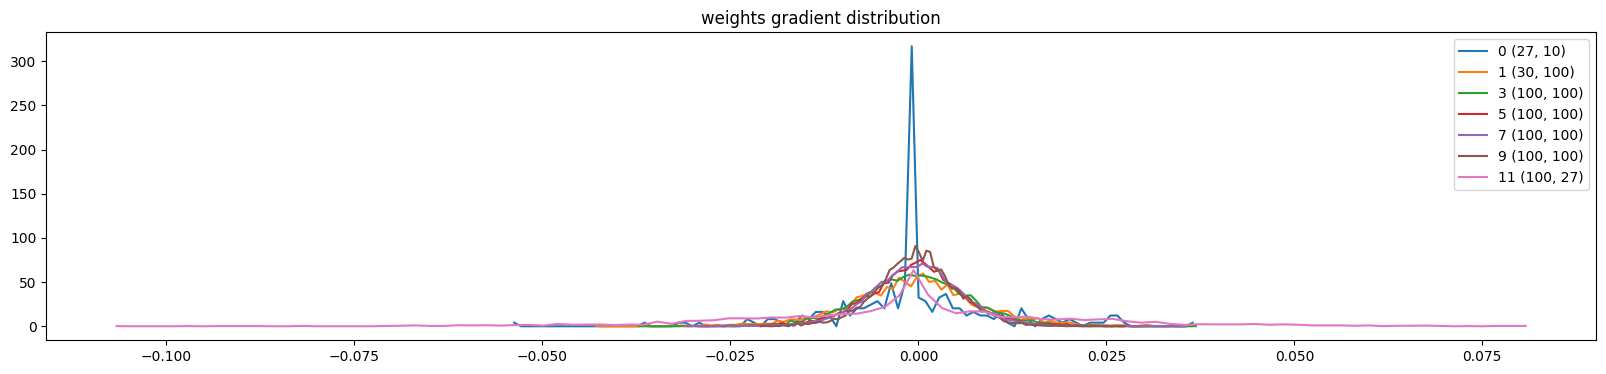

In [54]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print( "weight %10s | mean %+f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

This looks at the grdients of weights in all layers. grad:data ratio looks at the scale of weight's grad and weight's data - this should be low numbers. But the last layer (param 11) has 3e-1 which is high, this is because the layer is damped to produce low confidence initially (with scaling wieghts with 0.1), so grads are high to learn fast.

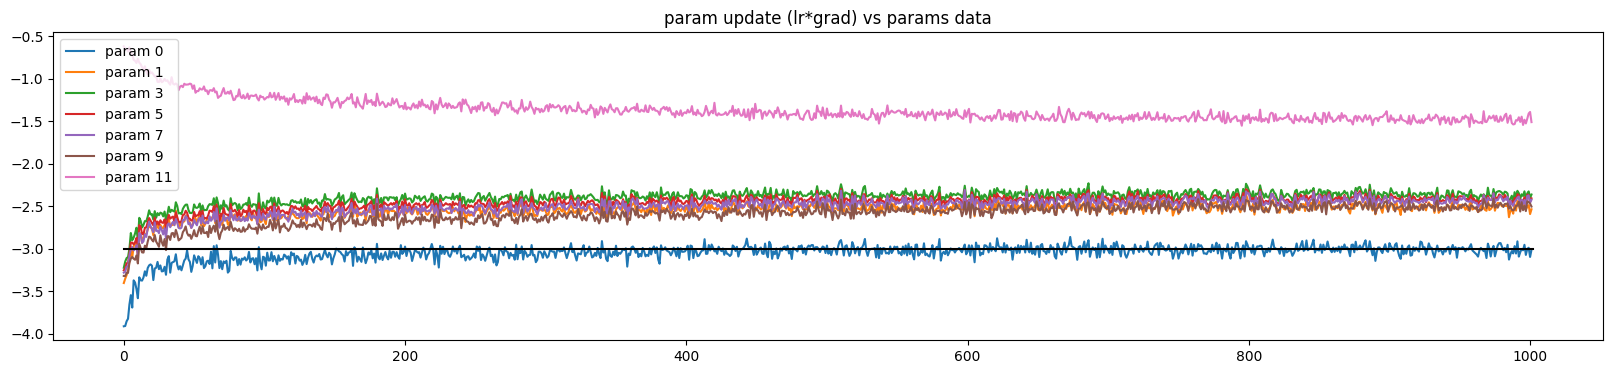

In [55]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title("param update (lr*grad) vs params data");

This looks at the update (lr * grad) vs weights of all layers in the network. This should be roughly close to ~1e-3. If it below, it is not learning fast enough. If it is **too** high, it is learning fast and lr should be lowered. 

All layer's params are getting updated close to 1e-3 other than param 11 (last layer) but it also closly saturating to close to 1e-3. If at all lr could be lowered a bit

### Introduction of Batch Norm

In [56]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

# weight init / update
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #<--- Proper scale for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [57]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000: 
        break  # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.3363


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.38%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.88%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.00%


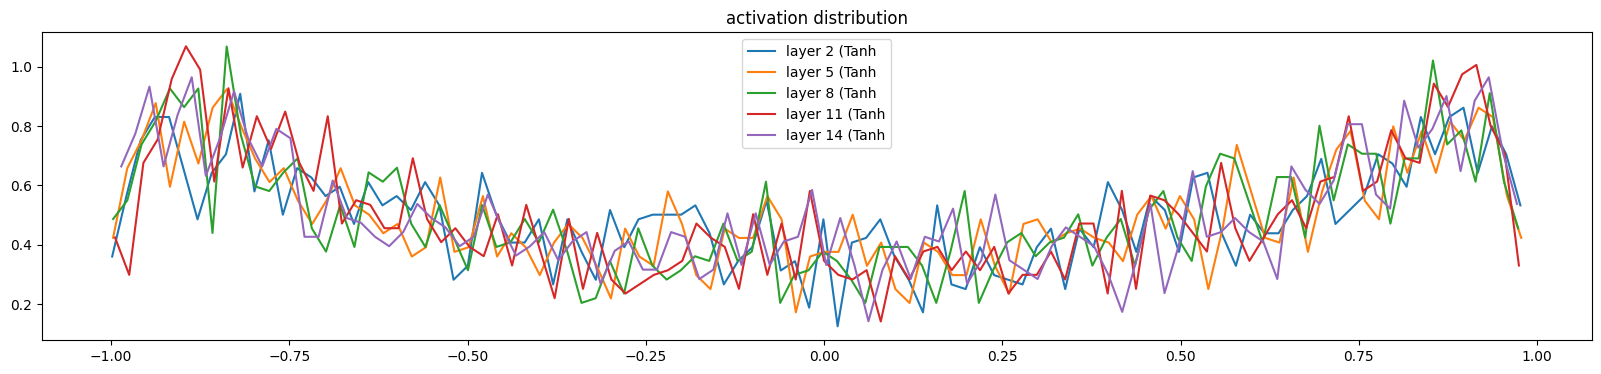

In [58]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"% (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100,))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution");

looks good

layer 2 (      Tanh): mean +0.000000, std 2.703296e-03
layer 5 (      Tanh): mean +0.000000, std 2.366812e-03
layer 8 (      Tanh): mean +0.000000, std 2.239128e-03
layer 11 (      Tanh): mean -0.000000, std 2.137454e-03
layer 14 (      Tanh): mean +0.000000, std 2.154571e-03


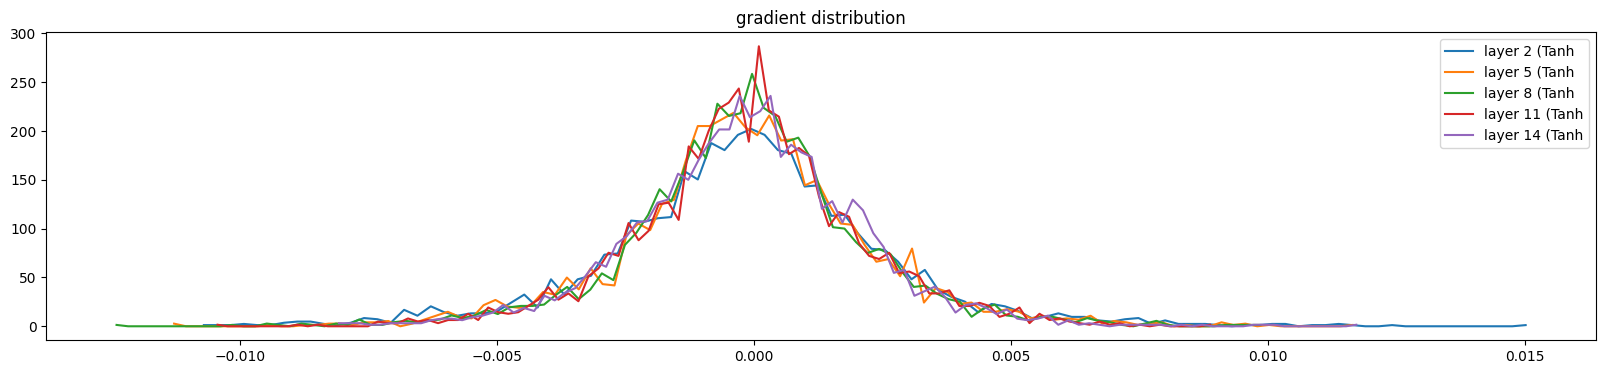

In [59]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e"% (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution");

looks good

weight   (27, 10) | mean +0.000000 | std 7.407484e-03 | grad:data ratio 6.711168e-03
weight  (30, 100) | mean -0.000252 | std 6.658835e-03 | grad:data ratio 2.159528e-02
weight (100, 100) | mean -0.000047 | std 5.583754e-03 | grad:data ratio 3.319929e-02
weight (100, 100) | mean -0.000010 | std 4.768386e-03 | grad:data ratio 2.847284e-02
weight (100, 100) | mean -0.000057 | std 4.660758e-03 | grad:data ratio 2.780070e-02
weight (100, 100) | mean -0.000005 | std 4.151135e-03 | grad:data ratio 2.460525e-02
weight  (100, 27) | mean +0.000082 | std 7.571686e-03 | grad:data ratio 4.543341e-02


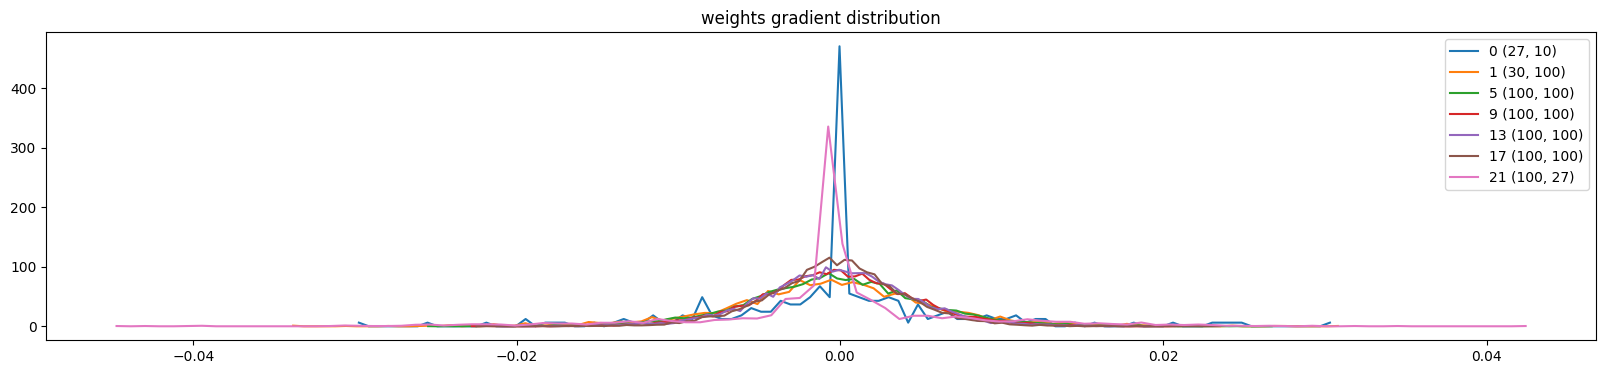

In [60]:
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print( "weight %10s | mean %+f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

looks good. Kinda first layers are squashed, this is to be expected.

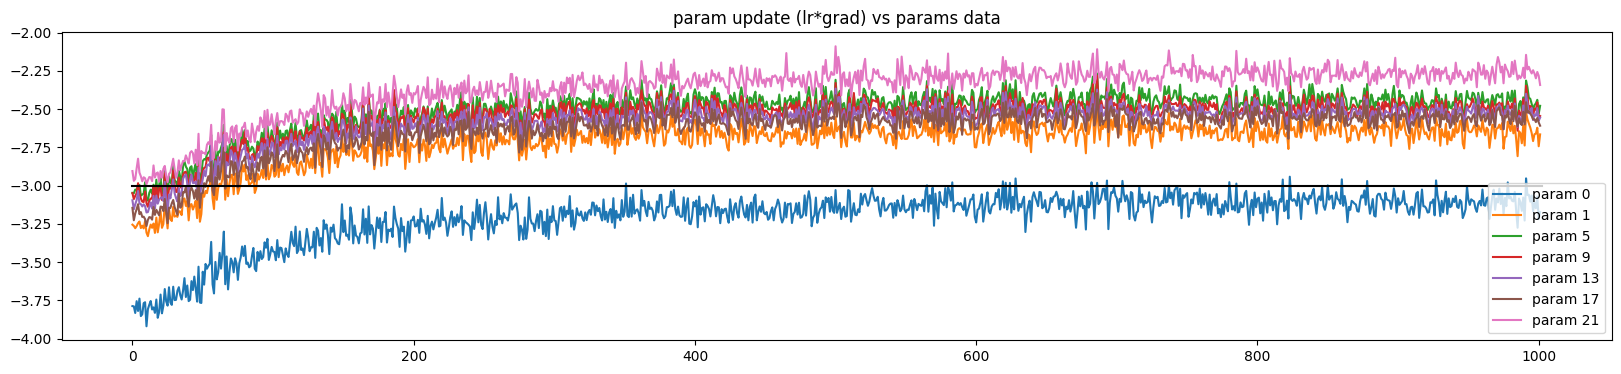

In [61]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title("param update (lr*grad) vs params data");

This is also roughly close to 1e-3. But this wont be the case if not inited properly even with BatchNorm. Example below

In [62]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

# weight init / update
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.2 # <---- Low scale

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [63]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000: 
        break  # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.3347


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 5 (      Tanh): mean +0.00, std 0.66, saturated: 1.69%
layer 8 (      Tanh): mean -0.00, std 0.66, saturated: 1.34%
layer 11 (      Tanh): mean +0.00, std 0.66, saturated: 0.78%
layer 14 (      Tanh): mean -0.00, std 0.67, saturated: 0.44%


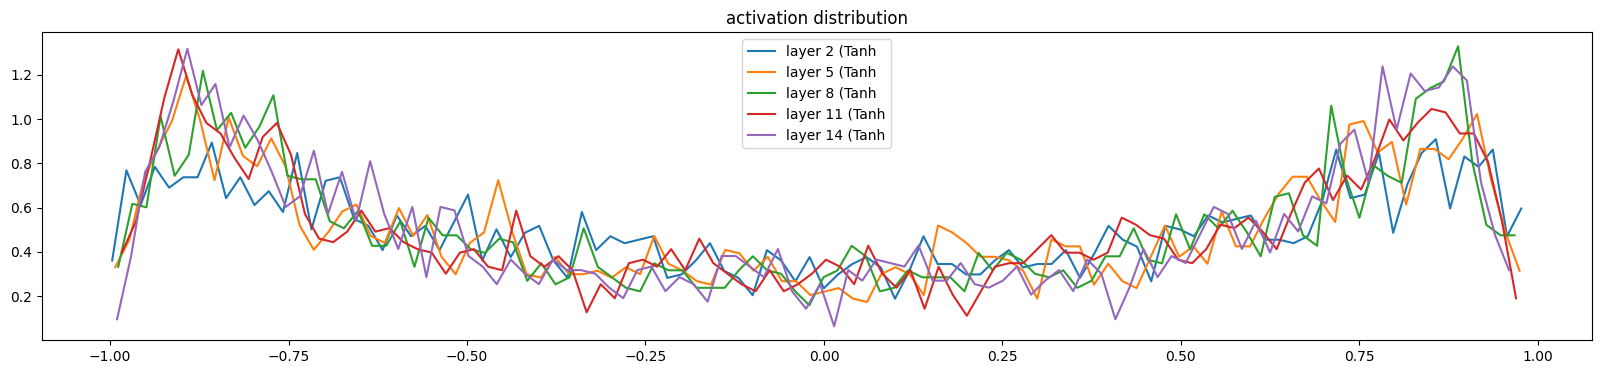

In [64]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"% (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100,))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution");

This looks good, because of Batch Norm

layer 2 (      Tanh): mean -0.000000, std 1.041635e-03
layer 5 (      Tanh): mean +0.000000, std 8.832814e-04
layer 8 (      Tanh): mean -0.000000, std 8.785826e-04
layer 11 (      Tanh): mean +0.000000, std 9.058564e-04
layer 14 (      Tanh): mean +0.000000, std 1.030289e-03


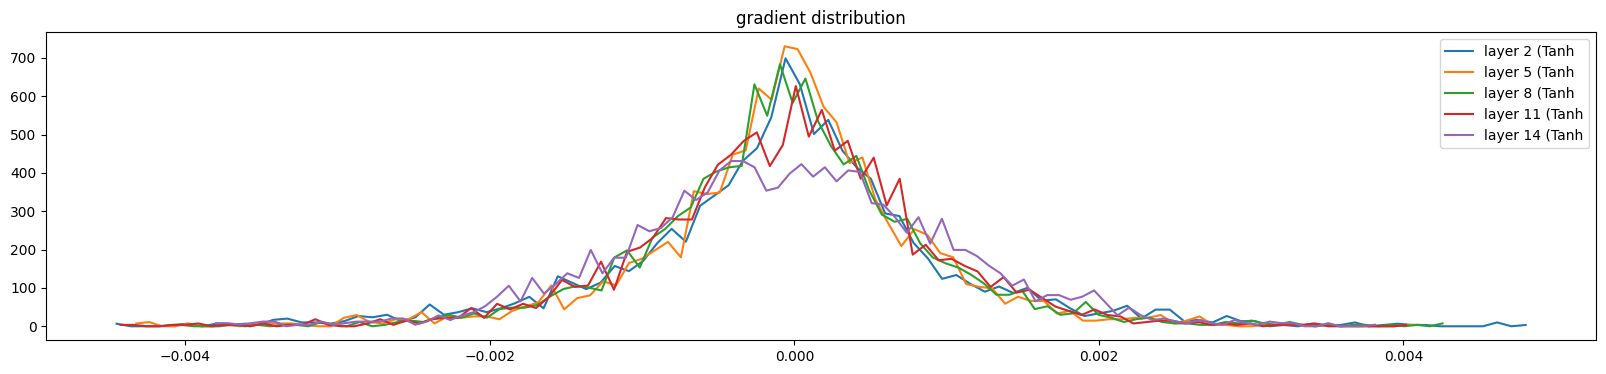

In [65]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e"% (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution");

looks good

weight   (27, 10) | mean -0.000000 | std 5.540473e-03 | grad:data ratio 5.018808e-03
weight  (30, 100) | mean -0.000318 | std 1.122677e-02 | grad:data ratio 1.881576e-01
weight (100, 100) | mean -0.000065 | std 5.434292e-03 | grad:data ratio 1.845245e-01
weight (100, 100) | mean +0.000062 | std 4.845872e-03 | grad:data ratio 1.775658e-01
weight (100, 100) | mean -0.000014 | std 4.808472e-03 | grad:data ratio 1.792973e-01
weight (100, 100) | mean -0.000017 | std 4.562149e-03 | grad:data ratio 1.683888e-01
weight  (100, 27) | mean +0.000099 | std 1.079068e-02 | grad:data ratio 2.357125e-01


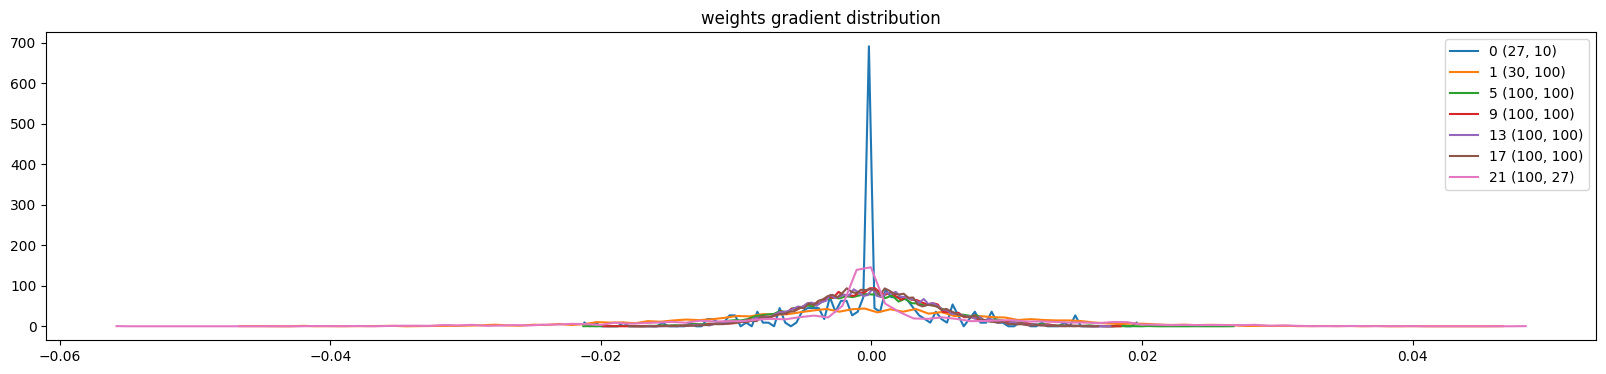

In [66]:
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print( "weight %10s | mean %+f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

First layers param is squashed like before.

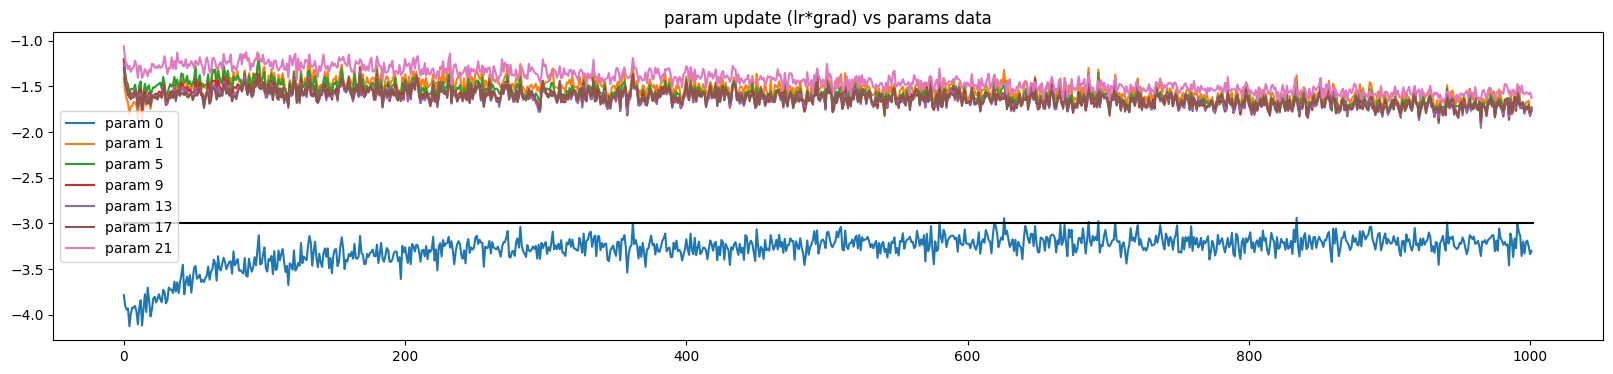

In [67]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title("param update (lr*grad) vs params data");

All layers are learning way to fast, because weights are not init'd properly.